# MongoPlanet-Archive

## Asignatura: Estructura y Base de Datos
## Profesor: Miguel Cárcamo

### Integrantes:
- Sebastián López

- Thomas Salazar

- Ignacio Solís

- Marcelo Andrade

### Fecha de entrega : 23/12/2024

## Introducción

MongoPlanet-Archive es un proyecto que utiliza los datos del Exoplanet Archive para crear una base de datos no relacional utilizando MongoDB. Nuestra idea es transformar datos extensos y complejos en un formato más accesible y estructurado, facilitando su interpretación y análisis. Como se menciona anteriormente el sistema de gestión de base de datos preferido para este proyecto es Mongodb, por su optimizacion de grandes sets de datos no relacionados, como es el caso de la Exoplanet Archive. Cabe mencionar que no se contemplara el uso de otros sistemas o frameworks de bases relacionadas, como puede ser: SQL, otro software NO-SQL y Apache-Spark, porque no vemos necesario dividir en tablas los elementos, ni complejizar el algortimo con mas programas, ni recurrir a aparatos que son mas útiles para mantener servicios en tiempo real; respectivamente.

## Objetivo

Diseñar un sistema de lectura de los datos del Exoplanet Archive utilizando Mongodb. Facilitar su exploración aplicando una categorización de los metodos de descubrimiento en colecciones. Además generar visualizaciones como histogramas para interpretar la información proporcionada por este catálogo una vez realizada la población del sistema. Adicionalmente de complementar con consultas para verificar el estado de la base de datos.

## Codigo de población 

Dado que necesitamos poblar una base de datos con un documento con el formato .csv descargado de la web [https://exoplanetarchive.ipac.caltech.edu/docs/data.html], el tipo de base de datos mas conveniente es uno NO-SQL del estilo documento, en nuestro caso usaremos Mongodb por la comodidad y facil implementacion de documentos a la base de datos a traves de este.

Para este proyecto usamos un archivo descargado de la pagina mencionada, en el apartado de data/planetary system, modificando para que no considere las columnas de: 

-Default Parameter Set

-Solution Type

-Controversial Flag

-Planet Radius [Earth Radius y Jupiter Radius]

-Insolation Flux [Earth Flux]

-Equilibrium Temperature [ K ]

La razón de que no esten estos datos en nuestro set de datos, es porque no contenian muchos datos, y que eran datos que su frecuencia eran redundantes, no siendo nuestra prioridad con nuestra base de datos.

A continuacion, se hace la población de la base de datos:

In [1]:
#Librerías
from pymongo import MongoClient
import pandas as pd


#Funciones
def create_profiles_collection(db, collection_name):
    '''esta funcion nos permite crear las colecciones en mongodb a través de db.create_collection
    ---------------------------------------------------------------------------------------------
    parametros: 
    1) db, será la base de datos
    2) collection_name será el nombre de la colección de MongoDB'''
    
    if collection_name not in db.list_collection_names():
        db.create_collection(collection_name)
    else:
        print(f"la colección'{collection_name}' ya existe.")

def insert_data_to_mongo(db, collection_name, data_frame):
    '''esta función sirve para ingresar datos de un dataframe a la colección de la base de datos de MongoDB
    -------------------------------------------------------------------------------------------------------
    parametros:
    1) db, será la base de datos
    2) colecction_name será el nombre de la colección donde se agregaran los datos
    3) data_frame será el dataframe obtenidos a partir del archivo exoplanets.csv'''
    
    collection = db[collection_name]
    records = data_frame.to_dict(orient='records')
    collection.insert_many(records)

#Lectura de datos del .csv
path = 'Exoplanet.csv'
df = pd.read_csv(path, skiprows = 41, header = 0)

#Creación de la base de datos
client = MongoClient("localhost", 27017)
db = client['Exoplanet_A'] # cramos la base de datos Exoplanet_A

#Contado de nombres para las colecciones
metodos = df['discoverymethod'].value_counts().keys()
dataframes_por_metodo = {}

#Filtración, creación de colecciones y poblamiento de base de datos segun el metodo de descubrimiento
for metodo in metodos:
    df_metodo = df[df["discoverymethod"] == metodo].drop(columns=["discoverymethod"]) #Filtro
    create_profiles_collection(db, metodo)  # Creación de colección
    insert_data_to_mongo(db, metodo, df_metodo)  # Inserción de datos

print('Se han creado las colecciones: ', db.list_collection_names())

Se han creado las colecciones:  ['Eclipse Timing Variations', 'Radial Velocity', 'Transit Timing Variations', 'Astrometry', 'Disk Kinematics', 'Transit', 'Pulsar Timing', 'Microlensing', 'Pulsation Timing Variations', 'Orbital Brightness Modulation', 'Imaging']


# Visualización de datos 
Una vez que nuestra base de datos esté completamente poblada con los datos de exoplanetas, es fundamental realizar visualizaciones para explorar y comprender mejor la información almacenada. A continuación, presentamos una serie de ejemplos y pasos prácticos para trabajar con las visualizaciones de datos extraídos de la base de datos.

### *Número de documentos de cada colección* 
Contar el número de documentos en cada colección es clave para obtener una visión general de los datos disponibles. Esto ayuda a identificar qué métodos de descubrimiento o categorías tienen más datos y orienta los análisis posteriores. Visualizar este conteo con un gráfico de barras permite interpretar fácilmente la distribución y densidad de los documentos en cada colección.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

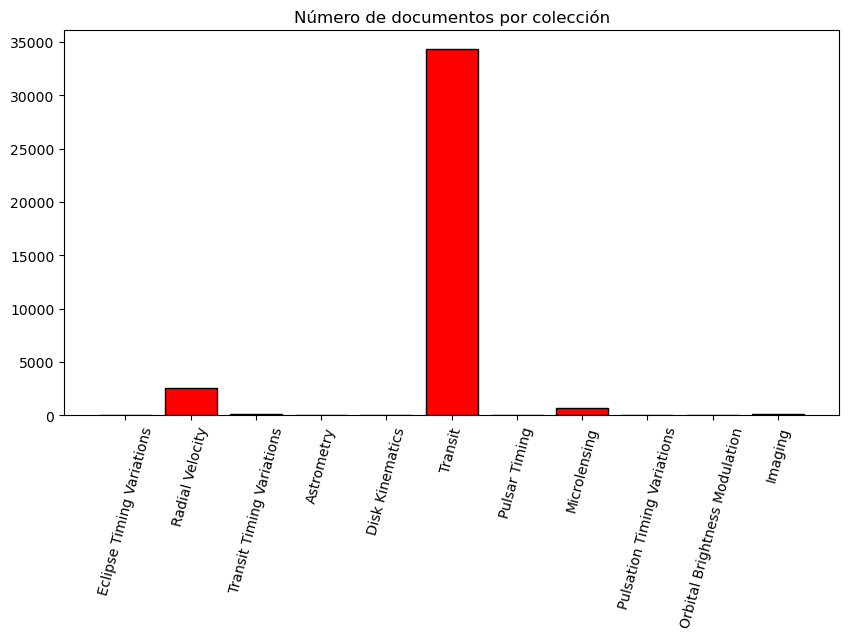

In [3]:
# Lista para almacenar los nombres de las colecciones y el número de documentos
num_documentos = []
colecciones = db.list_collection_names()

for coleccion in colecciones:
    count = db[coleccion].count_documents({})  # Contar documentos en la colección
    num_documentos.append(count)  # Almacenar la cantidad de documentos

# Diagrama Colecciones
plt.figure(figsize=(10, 5))
plt.bar(colecciones, num_documentos, color='red', edgecolor='black')
plt.title('Número de documentos por colección')
plt.xticks(rotation=75)  
plt.show()

### *Colecciones pequeñas*
Ahora que tenemos la visualización de los datos de una forma más detallada podemos filtrar las colecciones que tengan menos de 100 documentos. El objetivo de esto es poder categorizar las colecciones que tengan un tamaño insuficiente para poder hacer un estudio estadístico de forma cómoda con ellas y eliminarlas de la base de datos para economizar en eficiencia.

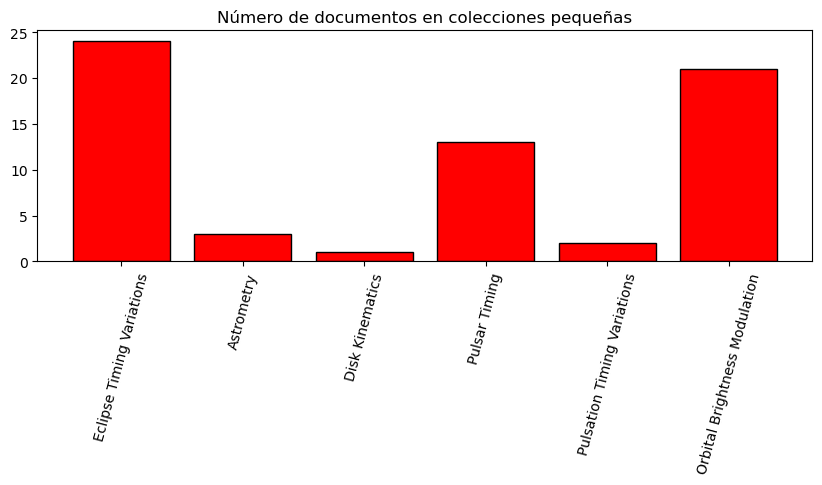

In [4]:
#Coleciones pequeñas y conteo
col_pequeñas = []
count_pequeñas = []

for coleccion in colecciones:
    count = db[coleccion].count_documents({})
    if count < 100: #Filtro
        col_pequeñas.append(coleccion)
        count_pequeñas.append(count)

# Diagrama colecciones pequeñas
plt.figure(figsize=(10, 3))
plt.bar(col_pequeñas, count_pequeñas, color='red', edgecolor='black')
plt.title('Número de documentos en colecciones pequeñas')
plt.xticks(rotation=75)  
plt.show()

In [5]:
#Eliminar las colecciones pequeñas
for col in col_pequeñas:
    db.drop_collection(col)

print(f'colecciones eliminadas: {col_pequeñas}')
print(f'Colecciones actuales: {db.list_collection_names()}')

colecciones eliminadas: ['Eclipse Timing Variations', 'Astrometry', 'Disk Kinematics', 'Pulsar Timing', 'Pulsation Timing Variations', 'Orbital Brightness Modulation']
Colecciones actuales: ['Radial Velocity', 'Transit Timing Variations', 'Transit', 'Microlensing', 'Imaging']


Hecho esto, ahora podremos centrarnos en las colecciones con una gran cantidad de documentos, dejándonos la libertad de hacer visualizaciones de todas las colecciones a la vez.

# *Consultas*
A continuación se dan 3 ejemplos de consulta posibles dentro de la base de datos.


##### 1. RA mayor a 200 [deg] para todas las colecciones

En este caso, queremos contar cuántas observaciones se encuentran dentro de una región del cielo con una ascensión recta superior a 200° en cada colección. Acto seguido, se debe generar un histograma individual para cada colección utilizando los datos filtrados.

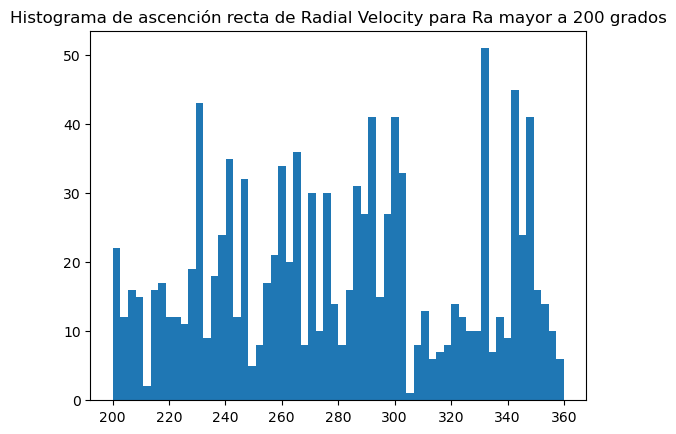

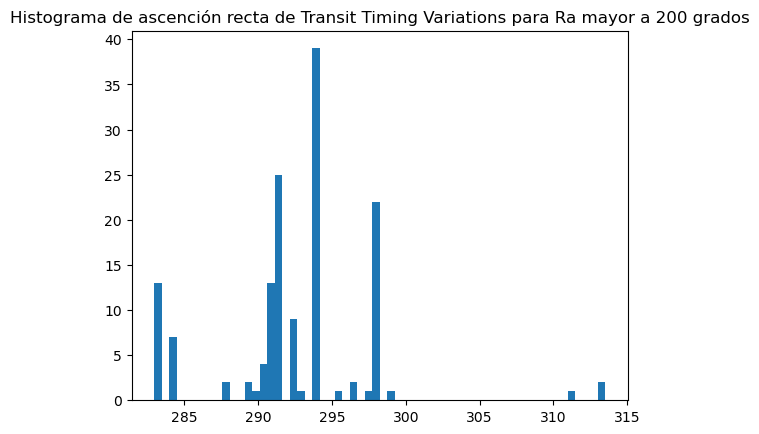

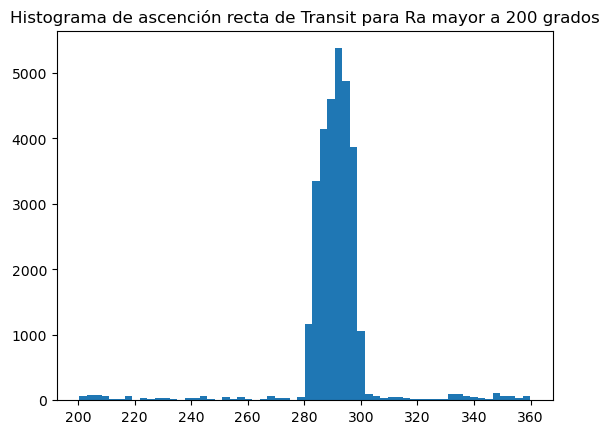

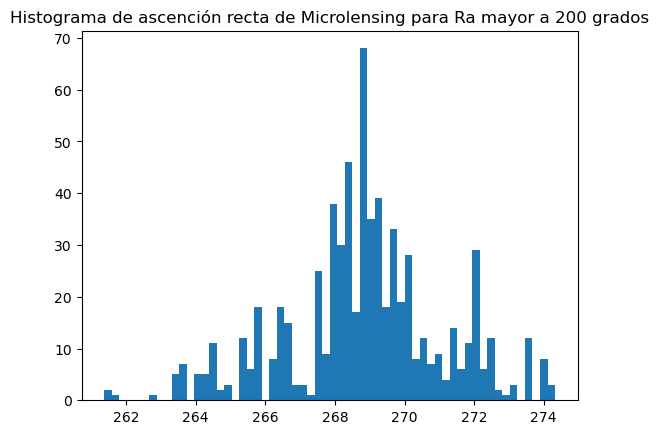

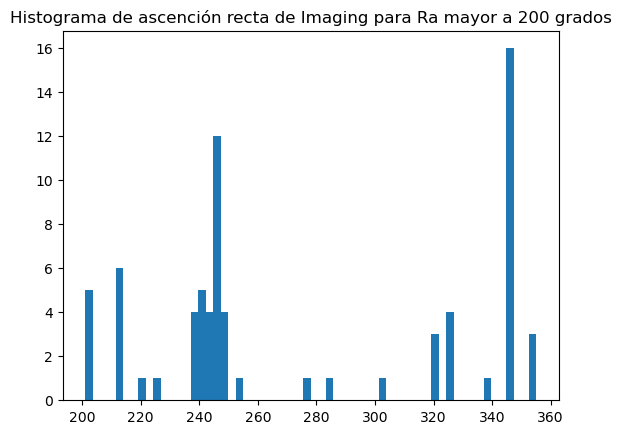

In [6]:
#Histograma del ra de los cuerpos con ra mayor a 200 [deg] en todas las colecciones
for colecciones in db.list_collection_names():
    RA = []
    for doc in db[colecciones].find(
        {'ra': {
            '$gt': 200
        }
        }):
        RA.append(doc['ra'])
    plt.hist(RA, bins = 60)
    plt.title(f'Histograma de ascención recta de {colecciones} para Ra mayor a 200 grados')
    plt.show()

Con los resultados obtenidos, podemos observar que se han efectuado numerosas observaciones entre 250° y 290°. Por ello, es posible reducir el rango del filtro para tener gráficos más condensados.

##### 2. Conteo de planetas dentro del rango de RA y [dec] para todas las colecciones

Aunque se asemeje a la consulta anterior, la diferencia radica en que queremos contar exclusivamente los planetas observados dentro de una sección del cielo delimitada por 100° < RA < 200° y -50° < DEC < 50°. Posteriormente, se debe generar un gráfico de barras para cada colección con los conteos de los planetas seleccionados.

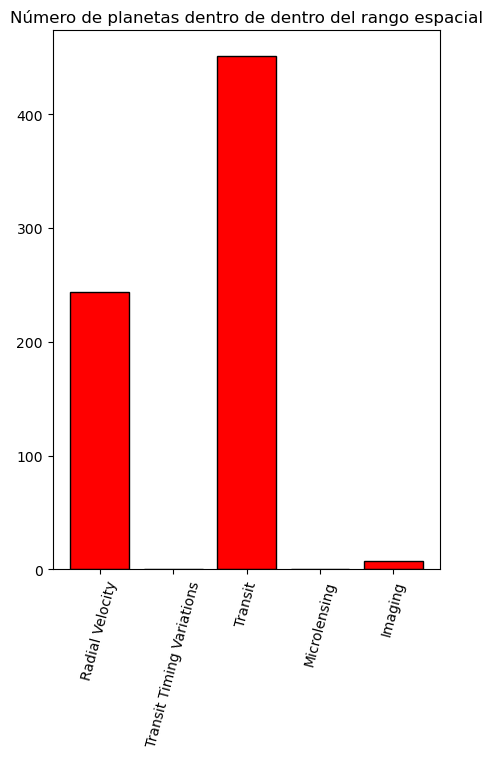

In [7]:
#Contar el número de planetas descubiertos por método en un rango específico de RA y DEC.

count = []
colecciones = db.list_collection_names()

for col_name in colecciones:
    planetas = []
    col = db[col_name]  # Acceder a la colección
    for doc in col.find({
        "$and": [
            {'ra': {'$gt': 100}, 'dec': {'$gt': -50}},  
            {'ra': {'$lt': 200}, 'dec': {'$lt': 50}}   
            ]
        }):

        #Verificamos si el planeta se repite
        if doc['pl_name'] not in planetas:
            planetas.append(doc['pl_name'])
        
    count.append(len(planetas))

plt.figure(figsize=(5, 7))
plt.bar(colecciones, count, color='red', edgecolor='black')
plt.title('Número de planetas dentro de dentro del rango espacial')
plt.xticks(rotation=75)  
plt.show() 

Dentro de estas coordenadas, se puede concluir que los planetas detectados a través del método del tránsito son los más frecuentes. Esto puede deberse a que justamente hay un cúmulo de estrellas que están muy pobladas por planetas, cuyos tamaños son lo suficientemente grandes para ser detectados con este método.

##### 3. Gráfica de los planetas donde su estrella supera en metalicidad al promedio para el método de Imaging

La consulta consiste de 2 partes, una para saber el promedio de todas las metalicidades de los planetas detectados con el método de imaging, incluyendo aquellos que están repetidos y sin considerar los valores NaN que existen en el sistema. Para luego hacer la consulta del nombre, RA y DEC de todos los planetas que tengan una metalicidad mayor a la ya calculada, considerando que al menos una de las observaciones de ese planeta cumpla con el valor de la metalicidad. Además, una vez hechas las consultas se deben transformar las coordenadas con astropy para que el formato del parámetro de entrada del gráfico sea el correcto.

In [9]:
from astropy.coordinates import SkyCoord
import astropy.units as u

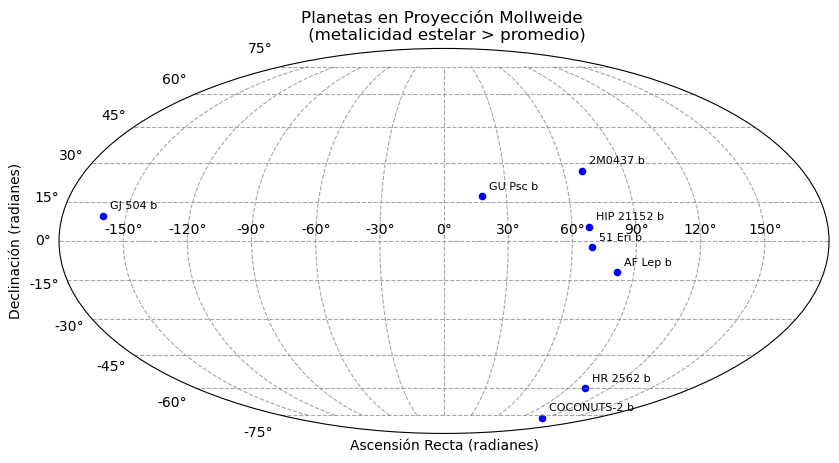

In [10]:
#Los planetas que fueron detectados a través del método de detección Imaging, que tengan una estrella con metalicidad mayor al promedio.

col = db['Imaging']
met = []

#Obtenemos el promedio
for doc in col.find():
    if not np.isnan(doc['st_met']):
        met.append(doc['st_met'])
met_prom = np.mean(met)


RA,DEC,Nombres = [],[],[]

#Encontramos los planetas
for doc in col.find({
    'st_met' : {
        '$gt' : met_prom}
    }):
    if doc['pl_name'] not in Nombres:
        
        RA.append(doc['ra'])
        DEC.append(doc['dec'])
        Nombres.append(doc['pl_name'])

# Convertimos RA y DEC a radianes usando Astropy
coords = SkyCoord(ra=RA * u.deg, dec=DEC * u.deg, frame='icrs')
RA_rad = coords.ra.wrap_at(180 * u.deg).radian  # En radianes, centrado en 180 grados
DEC_rad = coords.dec.radian  # Declinación en radianes

# Graficamos el mapa en proyección Mollweide
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(RA_rad, DEC_rad, marker='o', s=20, color='blue')
for k in range(len(Nombres)):  # Anotamos los nombres de los planetas
    ax.annotate(Nombres[k], (RA_rad[k], DEC_rad[k]), xytext=(5, 5),
                textcoords='offset points', fontsize=8, color='black')

ax.set_xlabel('Ascensión Recta (radianes)')
ax.set_ylabel('Declinación (radianes)')
ax.grid(True, color='gray', linestyle='--', alpha=0.7)
ax.set_title('Planetas en Proyección Mollweide \n (metalicidad estelar > promedio)')
plt.show()

Al parecer los resultados muestran que aquellos planetas detectados con el método de imaging fueron hechos enfocados en una región del universo con sistemas estelares muy activos en el pasado, ya que para que haya una metalicidad alta, debieron de haber transcurrido muchas generaciones estelares.

## Conclusión

En conclusión, a lo largo del proyecto pudimos comprobar la efectividad de las bases de datos de tipo documento, como MongoDB, para trabajar con datos no relacionales y de gran tamaño. Sus consultas son altamente eficientes, permitiendo aplicar filtros, realizar análisis estadísticos y localizar documentos específicos de manera ágil. Gracias a cómo se hizo la población de la base de datos,implica que en una circunstancia alterna podamos añadir más datos si es que lo necesitamos, simplemente sabiendo qué tipo de descubrimiento tienen los planetas que se añadirán a la base de datos. Una ventaja que podemos destacar es la implementación de la librería de PyMongo dentro de python, nos permitió ocupar otras herramientas para mejorar la visualización y transformación de los datos, como fue el caso de matplotlib y astropy. Mongoplanet Archive es un software versatil a para la fuente de datos de exoplanet archive, es decir, preferimos trabajar con Mongoplanet antes que cualquier otro sistema de bases de datos. Finalmente vemos a MongoDB como una herramienta que utilizariamos en un futuro para trabajar con bases de datos.